# Preprocessing SpikeGLX binary files
When you record with the SpikeGLX system it saves the data to binary files (\*.bin) with accompanying meta data (\*.meta). This includes both the neural data, which has an \*.imecX.\* string in its file names, and task/behavior data recorded with the NiDAQ board and has an \*.nidq.\* string. Those files ending in *.ap.bin can be subjected to spike sorting to extract the firing of individual neurons. Consult the tutorial 'RunSpikeSorting.ipynb' to learn how to do that.

Once spike sorting is completed, three additional steps should be performed: extraction of the local field potential, time alignment, and loading the all the time-alinged spike times as a pynapple TsGroup object. This tutorial covers how to do these steps.

### The easy way
To preprocess everything (after you ran spike sorting) in your session directory you can run the function `preprocess_spikeglx`. Be sure to specify the synchronization channel for the NIDAQ, and if it is not channel 384 for the AP binary files. 

In [ ]:
from mimo_pack.preprocess.session import preprocess_spikeglx

sess_dir = 'D:\\SortingTemp\\2024-08-14_DH37_Reaching_g0'
preprocess_spikeglx(sess_dir, sync_nidq={'channel': [13]}, use_catgt_version=False)

### Identify the files to process
For both steps we have to find the files to process. To do that, we will search the directory containing all the SpikeGLX data from a given recording session.

In [1]:
from mimo_pack.util.files import find_all_matching_files
import os

# find all the files in a directory and its subdirectories
exp_dir = "D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0" # set this to the directory for the recording session
ap_files = find_all_matching_files(exp_dir, r't0\.imec([0-9]+)\.ap\.bin')
nidq_file = find_all_matching_files(exp_dir, r't0\.nidq\.bin')[0] # there should be only one nidq file

print("ap files:")
for f in ap_files:
    print(f)

print("nidq file:")
print(nidq_file)

ap files:
D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec0\24-05-31_DH23_A1-IC_g0_t0.imec0.ap.bin
D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec1\24-05-31_DH23_A1-IC_g0_t0.imec1.ap.bin
nidq file:
D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_t0.nidq.bin


### Extraction of LFP
To extract the LFP signals, you can use functions found in `mimo_pack.preprocess.lfp`. These take an *.ap.bin binary file, low pass filter it to remove high frequency signals and reduce aliasing, downsample the signal, and then save it to a new binary file with the same base name but ending in *.lfp.bin. The function `make_lfp_file_spikeglx` by default low pass filters at 500 Hz and resamples at 1000 Hz. Following creation of the LFP binary file, a dclut meta file can be created using the *.meta file associated with the original *.ap.bin binary file.

In [2]:
from mimo_pack.preprocess.lfp import make_lfp_file_spikeglx, dclut_from_meta_lfp

lfp_files = []
lfp_dclut_files = []
# make a LFP file from the imec files
for ap_file in ap_files:
    print('Processing {}'.format(os.path.basename(ap_file)))
    lfp_files.append(make_lfp_file_spikeglx(ap_file, verbose=True))
    lfp_dclut_files.append(dclut_from_meta_lfp(lfp_files[-1]))

Processing 24-05-31_DH23_A1-IC_g0_t0.imec0.ap.bin


100%|██████████| 451/451 [7:10:05<00:00, 57.22s/it]  


Processing 24-05-31_DH23_A1-IC_g0_t0.imec1.ap.bin


100%|██████████| 451/451 [7:14:52<00:00, 57.85s/it]  


### Time alignment
Next we want to ensure that a common temporal reference frame is shared across all our files. For that we choose the first imec recording file (*.imec0.ap.bin) to be our reference and all other files are keyed off of that one. Each imec file will have a synchronization signal on channel 384. For the nidq file, the synchronization signal will be on whichever channel it had been plugged into on the NiDAQ card.

The alignment is stored using dclut meta files. When we created our LFP files these were made, but they have not yet been created for the *.ap.bin and *.nidq.bin files. So first we will create those.

In [3]:
lfp_dclut_files = find_all_matching_files(exp_dir, r't0\.imec([0-9]+)\.lfp_dclut\.json')
lfp_dclut_files

['D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec0\\24-05-31_DH23_A1-IC_g0_t0.imec0.lfp_dclut.json',
 'D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec1\\24-05-31_DH23_A1-IC_g0_t0.imec1.lfp_dclut.json']

In [4]:
# Create dclut files for ap and nidq files
from mimo_pack.fileio.spikeglx import dclut_from_meta

ap_dclut_files = [dclut_from_meta(f) for f in ap_files]
nidq_dclut_file = dclut_from_meta(nidq_file)

Now that all our files have associated dclut files, we can align them. The function `align_sync_dclut` loads the synchonization signal from two binary files (a *target* and a *reference*) with associated dclut meta data, identifies where those synchronization signals align, creates a table of the indices in the *target* file and their corresponding time stamps in the *reference* file, and returns a new dclut file for the *target* file with a new time scale that uses the alignment table. `align_sync_dclut` has five required inputs:
1. path_t : a string of the file path to the target's dclut file
2. path_r : a string of the file path to the reference's dclut file
3. sync_t : a dictionary passed to the `.points` method of a dclut object that specifies the synchronization channel for the target, e.g. `{'channel': [384]}`
4. sync_r : a dictionary passed to the `.points` method of a dclut object that specifies the synchronization channel for the reference.
5. sync_scale_name : a string with the name of the scale that corresponds time in both dclut files, e.g. `'time'`


In [5]:
from mimo_pack.preprocess.time import align_sync_dclut

# Align the AP files to the first one
ap_r = ap_dclut_files[0] 
sync_pt = {'channel': [384]}
sync_scale_name = 'time'
for ap_t in range(1, len(ap_dclut_files)):
    file_t = ap_dclut_files[ap_t]
    print('Aligning {} to {}'.format(os.path.basename(file_t), os.path.basename(ap_r)))
    align_sync_dclut(file_t, ap_r, sync_pt, sync_pt, sync_scale_name, verbose=True)

# Align the LFP files to the first AP file
for lfp_t in range(len(lfp_dclut_files)):
    file_t = lfp_dclut_files[lfp_t]
    print('Aligning {} to {}'.format(os.path.basename(file_t), os.path.basename(ap_r)))
    align_sync_dclut(file_t, ap_r, sync_pt, sync_pt, sync_scale_name, verbose=True)

# Align the NIDQ file to the first AP file
sync_nidq_pt = {'channel': [5]}
print('Aligning {} to {}'.format(os.path.basename(nidq_dclut_file), os.path.basename(ap_r)))
align_sync_dclut(nidq_dclut_file, ap_r, sync_nidq_pt, sync_pt, sync_scale_name, verbose=True)

Aligning 24-05-31_DH23_A1-IC_g0_t0.imec1.ap_dclut.json to 24-05-31_DH23_A1-IC_g0_t0.imec0.ap_dclut.json
Reading target file


100%|██████████| 451/451 [25:30<00:00,  3.39s/it]


Reading reference file


100%|██████████| 451/451 [25:19<00:00,  3.37s/it]


Aligning sync signals


100%|██████████| 33688/33688 [00:03<00:00, 9718.11it/s] 


Aligning 24-05-31_DH23_A1-IC_g0_t0.imec0.lfp_dclut.json to 24-05-31_DH23_A1-IC_g0_t0.imec0.ap_dclut.json
Reading target file


100%|██████████| 451/451 [00:50<00:00,  9.00it/s]


Reading reference file


100%|██████████| 451/451 [25:11<00:00,  3.35s/it]


Aligning sync signals


100%|██████████| 33688/33688 [00:03<00:00, 9294.70it/s] 


Aligning 24-05-31_DH23_A1-IC_g0_t0.imec1.lfp_dclut.json to 24-05-31_DH23_A1-IC_g0_t0.imec0.ap_dclut.json
Reading target file


100%|██████████| 451/451 [00:50<00:00,  8.99it/s]


Reading reference file


100%|██████████| 451/451 [25:11<00:00,  3.35s/it]


Aligning sync signals


100%|██████████| 33688/33688 [00:03<00:00, 9647.70it/s] 


Aligning 24-05-31_DH23_A1-IC_g0_t0.nidq_dclut.json to 24-05-31_DH23_A1-IC_g0_t0.imec0.ap_dclut.json
Reading target file


100%|██████████| 451/451 [00:14<00:00, 31.14it/s]


Reading reference file


100%|██████████| 451/451 [25:02<00:00,  3.33s/it]


Aligning sync signals


100%|██████████| 33688/33688 [00:03<00:00, 9957.78it/s] 


'D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_t0.nidq_dclut.json'

### Verifying the alignment
Now that everything is synchronized, we should spot check the quality of the time alignment. If signals are perfectly aligned, then the signals on their sync pulse channels should be perfectly matched.

D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec0\24-05-31_DH23_A1-IC_g0_t0.imec0.ap_dclut.json
D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec1\24-05-31_DH23_A1-IC_g0_t0.imec1.ap_dclut.json
D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec0\24-05-31_DH23_A1-IC_g0_t0.imec0.lfp_dclut.json
D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec1\24-05-31_DH23_A1-IC_g0_t0.imec1.lfp_dclut.json
D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_t0.nidq_dclut.json


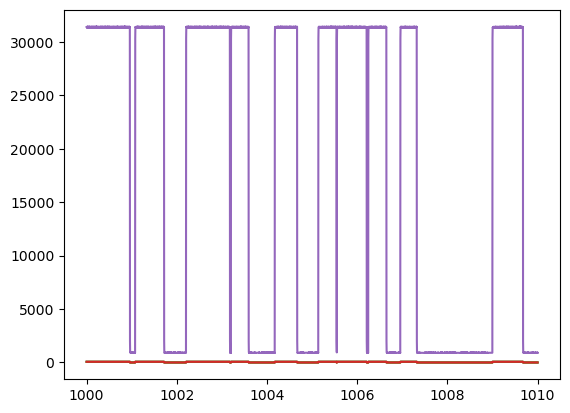

In [6]:
import matplotlib.pyplot as plt
from dclut import dclut

files = ap_dclut_files + lfp_dclut_files + [nidq_dclut_file]
is_nidq = [False] * (len(files)-1) + [True] # the last file is the nidq file
sample = {'time': [1000, 1010]}
signals = []
for f in range(len(files)):
    print(files[f])
    dcl = dclut(files[f])
    dcl.intervals(sample)
    if is_nidq[f]:
        dcl.points(sync_nidq_pt)
    else:
        dcl.points(sync_pt)
    signals.append(dcl.read(format='xarray'))

# find pulse onsets in reference signal
ref_signal = signals[0][0].data
fig, ax = plt.subplots()
for s in signals:
    ax.plot(s[0].time, s[0].data)

### Loading spike times
Now that all our files have had their times aligned, we can load the spiking activity from each of them and place them into a single pynapple TsGroup object. To do this, you should first have run spike sorting using Kilosort (see the tutorial [RunSpikeSorting](https://github.com/dbheadley/mimo_pack/blob/main/tutorials/RunSpikeSorting.ipynb)), and then manually curated the units it identified using [SortaSort2](https://github.com/dbheadley/SortaSort2). The results of spike sorting will be stored in the 'Kilosort4' subdirectory, and by default the curated spike files will have a '_sas' suffix. 

We will load the spiking data from each probe separately using the `as_pynapple` function and then combine the TsGroups. This function takes three arguments. First is the `phy_dir` argument, which is the Kilosort4 created directory where the spiking data is stored (as files consistent with the Phy2 program format). Next is the  `dcl_file` argument, which is the file path for the dclut json file that has the aligned time axis. Last is the `suffix` argument, which allows you to specify the suffix appended to the 'spike_times' and 'spike_clusters' files that were returned by SortaSort2 (usually '_sas').

In [7]:
import re
from mimo_pack.fileio.loadphy import as_pynapple

# for each ap dclut file path, create the corresponding kilosort4 directory
kilosort_dirs = [os.path.split(dclut_path)[0] + '\\kilosort4' 
                 for dclut_path in ap_dclut_files]

# load spikes as TsGroup objects
spikes = [as_pynapple(kilosort_dirs[i], dcl_file=ap_dclut_files[i], suffix='_sas') 
          for i in range(len(ap_dclut_files))]

Once you have loaded the spike data as a list of TsGroup objects (here stored in `spikes`), we want to add some metadata to the spikes to know which probes they came from. The code to do that is:

In [8]:
# get the probe name from dclut file
probe_names = [re.match(r'.*(imec[0-9]+)\.ap_dclut\.json', dclut_path).group(1) 
               for dclut_path in ap_dclut_files]

# add probe name to each TsGroup object
for i in range(len(spikes)):
    spikes[i].set_info(probe=[probe_names[i]]*len(spikes[i]))

This step is crucial, because the next thing we do is merge all the spikes recorded across all probes. The merging process will renumber the spike IDs, so the only way to tell which probe they came from is to have that metadata included with each spike. The TsGroup object has a `merge` method that allows you to take two TsGroup objects and concatenate them.

In [9]:
# combine into a single TsGroup object
all_spikes = spikes[0]
for i in range(1,len(spikes)):
    all_spikes = all_spikes.merge(spikes[i], reset_index=True, reset_time_support=True)

# get just the single and multiunit spikes as separate TsGroup objects
su = all_spikes.getby_category('class')['SU']
mu = all_spikes.getby_category('class')['MU']

Once merged into `all_spikes`, we separated units based on whether they were single units or multiunits according to label we gave in SortaSort2. When a dclut json file is passed to `as_pynapple` to load your spikes then each unit's location on the probe (x and y coordinate of the electrode where the waveform was largest) and the spike waveform on the 8 nearest electrodes. You can see this if you pass the TsGroup object to the `print` function.

In [10]:
print(su)

Index    rate      class    x      y       waveform                                                                                                                                                                                                                                                ...
-------  --------  -------  -----  ------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  -----
1        0.6188    SU       27.0   3225.0  {'waveform': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,                                                                                                                                                                                 ...
                                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           

To get a sense of your unit quality, you can plot some of their waveforms. 

Text(0.5, 1.0, 'Spike waveform')

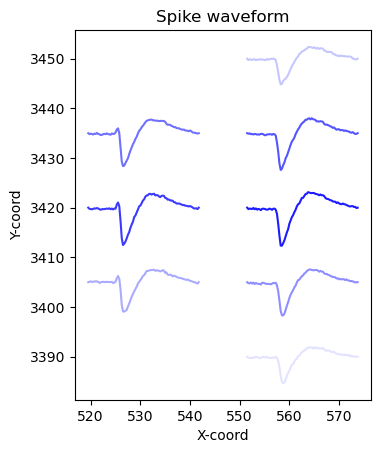

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# pull out the waveform data from the SU TsGroup object
su_waves = su.get_info('waveform')
indices = su.keys()
ind = indices[64]

# plot the waveforms
for i in range(8):
    plt.plot(np.arange(-30,60)/4+su_waves[ind]['x'][i],
         su_waves[ind]['waveform'][:,i]/4+su_waves[ind]['y'][i], 
         color='blue', alpha=(i+1)/9)

plt.gca().set_aspect('equal')
plt.xlabel('X-coord')
plt.ylabel('Y-coord')
plt.title('Spike waveform')